In [5]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.insert(0, module_path)

In [6]:
import ccd
from test.shared import read_data

In [7]:
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
%matplotlib inline

In [8]:
data = read_data('../test/resources/test_3657_3610_observations.csv')
dates, blues, greens, reds, nirs, swir1s, swir2s, thermals, qas = data
results = ccd.detect(dates, blues, greens, reds, nirs, swir1s, swir2s, thermals, qas, duplicate_dates=True)

2017-03-30 14:26:53 procedures::fit_procedure        - [50 ]Procedure selected: standard_procedure
2017-03-30 14:26:53 procedures::standard_procedure   - [205]Build change models - dates: 443, obs: (7, 443), meow_size: 12, peek_size: 6
2017-03-30 14:26:53 procedures::standard_procedure   - [229]Processing mask initial count: 295
2017-03-30 14:26:53 procedures::standard_procedure   - [249]Variogram values: [ 107.  131.  154.  235.  177.  151.  400.]
2017-03-30 14:26:53 procedures::standard_procedure   - [254]Initialize for change model #: 1
2017-03-30 14:26:53 change    ::initialize           - [353]Initial slice(0, 12, None)
2017-03-30 14:26:53 change    ::find_time_index      - [163]Sufficient time from times[0..12] (day #723883 to #724867)
2017-03-30 14:26:53 change    ::initialize           - [363]Checking window: slice(0, 12, None)
2017-03-30 14:26:53 change    ::initialize           - [373]Number of Tmask outliers found: 0
2017-03-30 14:26:53 change    ::initialize           - [41

d:\projects\lcmap-pyccd\ccd\math_utils.py:59: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 1; dimension is 295 but corresponding boolean dimension is 292
  return calculate_variogram(observations[:, indices])


2017-03-30 14:26:53 change    ::initialize           - [373]Number of Tmask outliers found: 0
2017-03-30 14:26:53 change    ::initialize           - [410]Generating models to check for stability
2017-03-30 14:26:53 change    ::stable               - [47 ]Stability norm: 89.9319355025, Check against: 15.086272469388987
2017-03-30 14:26:53 change    ::initialize           - [419]Unstable model, shift window to: slice(19, 31, None)
2017-03-30 14:26:53 change    ::find_time_index      - [163]Sufficient time from times[19..31] (day #725155 to #725539)
2017-03-30 14:26:53 change    ::initialize           - [363]Checking window: slice(19, 31, None)
2017-03-30 14:26:53 change    ::initialize           - [373]Number of Tmask outliers found: 0
2017-03-30 14:26:53 change    ::initialize           - [410]Generating models to check for stability
2017-03-30 14:26:53 change    ::stable               - [47 ]Stability norm: 88.4447149048, Check against: 15.086272469388987
2017-03-30 14:26:53 change    

Start Date: 1982-12-04 00:00:00
End Date: 2014-11-02 00:00:00

Result: 0
Start Date: 1984-04-21 00:00:00
End Date: 1988-04-16 00:00:00
Break Date: 1988-05-18 00:00:00
QA: 14
Norm: 0.0

Change prob: 0
Result: 1
Start Date: 1988-05-18 00:00:00
End Date: 1993-05-16 00:00:00
Break Date: 1993-06-01 00:00:00
QA: 8
Norm: 2313.8614499510954

Change prob: 1
Result: 2
Start Date: 1994-04-17 00:00:00
End Date: 2003-06-13 00:00:00
Break Date: 2003-06-29 00:00:00
QA: 8
Norm: 2278.655299010482

Change prob: 1
Result: 3
Start Date: 2011-04-24 00:00:00
End Date: 2014-07-13 00:00:00
Break Date: 2014-07-13 00:00:00
QA: 8
Norm: 331.9604729503696

Change prob: 0


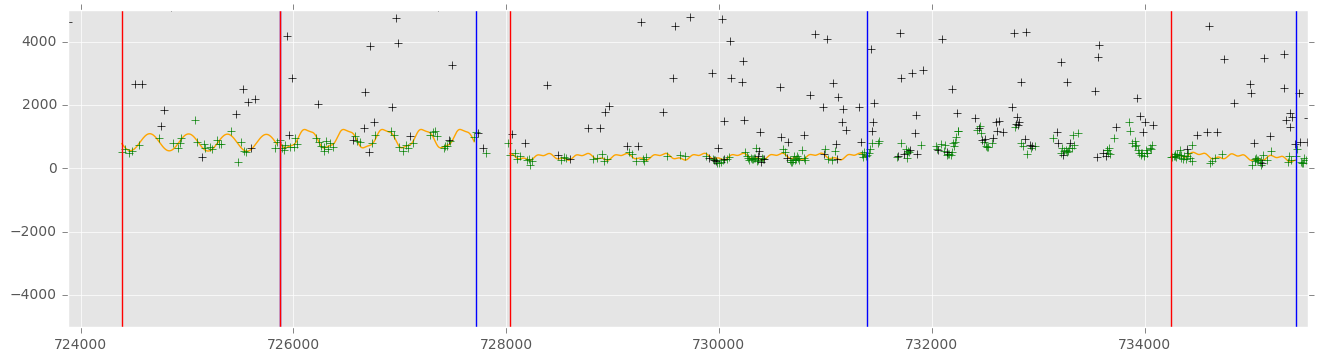

In [9]:
mask = results['processing_mask']
print('Start Date: {0}\nEnd Date: {1}\n'.format(datetime.fromordinal(dates[0]),
                                                datetime.fromordinal(dates[-1])))

predicted_values = []
prediction_dates = []
break_dates = []
start_dates = []

for num, result in enumerate(results['change_models']):
    print('Result: {}'.format(num))
    print('Start Date: {}'.format(datetime.fromordinal(result.start_day)))
    print('End Date: {}'.format(datetime.fromordinal(result.end_day)))
    print('Break Date: {}'.format(datetime.fromordinal(result.break_day)))
    print('QA: {}'.format(result.curve_qa))
    print('Norm: {}\n'.format(np.linalg.norm([result.green.magnitude,
                                            result.red.magnitude,
                                            result.nir.magnitude,
                                            result.swir1.magnitude,
                                            result.swir2.magnitude])))
    print('Change prob: {}'.format(result.change_probability))
    
    days = np.arange(result.start_day, result.end_day + 1)
    prediction_dates.append(days)
    break_dates.append(result.break_day)
    start_dates.append(result.start_day)
    
    intercept = result.green.intercept
    coef = result.green.coefficients
    
    predicted_values.append(intercept + coef[0] * days +
                            coef[1]*np.cos(days*1*2*np.pi/365.25) + coef[2]*np.sin(days*1*2*np.pi/365.25) +
                            coef[3]*np.cos(days*2*2*np.pi/365.25) + coef[4]*np.sin(days*2*2*np.pi/365.25) +
                            coef[5]*np.cos(days*3*2*np.pi/365.25) + coef[6]*np.sin(days*3*2*np.pi/365.25))
    
plt.style.use('ggplot')

fg = plt.figure(figsize=(16,9), dpi=300)
a1 = fg.add_subplot(2, 1, 1, xlim=(min(dates), max(dates)), ylim=(-5000, 5000))

# Predicted curves
for _preddate, _predvalue in zip(prediction_dates, predicted_values):
    a1.plot(_preddate, _predvalue, 'orange', linewidth=1)

a1.plot(dates[mask], greens[mask], 'g+') # Observed values
a1.plot(dates[~mask], greens[~mask], 'k+') # Observed values masked out
for b in break_dates: a1.axvline(b)
for s in start_dates: a1.axvline(s, color='r')